In [ ]:
from scipy.stats import uniform as uniform, norm as gaussian
from sklearn import preprocessing
import matplotlib.pyplot as plt

import numpy as np
import os
import time

import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.optim as optim
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, init_to_feasible, init_to_mean
from numpyro.infer.autoguide import AutoNormal
from numpyro import handlers
from numpyro.contrib.module import random_flax_module
from flax import linen as nn

from typing import Sequence, List
import arviz as az


np.random.seed(0)
rng_key = random.PRNGKey(0)
numpyro.set_platform('cpu')
plt.style.use('default')


#### Some of the metrics and functions needed 

In [7]:

def credintr(y_true, y_model) -> float:
    # mean_pred = jnp.mean(y_model, axis = 0)
    lower_pred = jnp.quantile(y_model, q = 0.0275, axis = 0)
    upper_pred = jnp.quantile(y_model, q = 0.975, axis = 0)
    i = 0
    for m in range(len(y_true)):
        if y_true[m] > lower_pred[m] and y_true[m] < upper_pred[m]:
            i+=1
    return i/len(y_true)

def rmse(y_true, y_model) -> float:
    return jnp.sqrt(jnp.mean((y_true.reshape(y_model.shape) - y_model)**2))

def log_lik(y_true, y_mean_samples, y_std_samples) -> float:
    return gaussian.logpdf(y_true, loc = y_mean_samples, scale = jnp.full(shape = y_mean_samples.shape, fill_value = y_std_samples.reshape(-1, 1)))

def WAIC(y_true, y_mean_samples, y_std_samples) -> float:
    # lppd = jnp.log(jnp.exp(log_lik(y_true, y_mean_samples, y_std_samples)).mean(axis =0)).sum()
    lppd = jnp.log(gaussian.pdf(y_true, loc = y_mean_samples, scale = jnp.full(shape = y_mean_samples.shape, fill_value = y_std_samples.reshape(-1, 1))).mean(axis =0)).sum()
    p_waic = jnp.sum(log_lik(y_true, y_mean_samples, y_std_samples).var(axis =0))
    elpdwaic = lppd - p_waic
    return -2*elpdwaic, lppd, p_waic


###  Base for the with ReLU or sigmoid activation

In [8]:
class FlaxMLP_relu(nn.Module):
    hidden_dims: Sequence[int]
    
    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:

        for i, hidden_dim in enumerate(self.hidden_dims, 1):
            x = nn.Dense(features = hidden_dim, name=f"Dense{i}")(x)
            x = nn.relu(x)
        x = nn.Dense(1, name=f"Dense{len(self.hidden_dims) +1}")(x)
        return x.squeeze()

In [9]:
class FlaxMLP_sigmoid(nn.Module):
    hidden_dims: Sequence[int]
    
    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:

        for i, hidden_dim in enumerate(self.hidden_dims, 1):
            x = nn.Dense(features = hidden_dim, name=f"Dense{i}")(x)
            x = nn.sigmoid(x)
        x = nn.Dense(1, name=f"Dense{len(self.hidden_dims) +1}")(x)
        return x.squeeze()

### Class which helps to initialize, do the inference of choice and provide predictions

In [10]:

class BNN:

    def __init__(self, hidden_dims: List[int] = None, activation: str = None, init_loc = None) -> None:
        self.hidden_dims = hidden_dims if hidden_dims is not None else [20,20]
        if init_loc is not None:
            self.init_loc = init_loc
        else:
            if len(self.hidden_dims) < 3:
                self.init_loc = init_to_feasible
            else:
                self.init_loc = init_to_mean
                
        if activation == 'ReLU':
            self.nn = FlaxMLP_relu(self.hidden_dims)
        else:
            self.nn = FlaxMLP_sigmoid(self.hidden_dims)
        self.priordict = {f"Dense{i}.bias": dist.Normal(0,0.5/len(self.hidden_dims)**0.5) for i in range(1,len(self.hidden_dims)+2)}
        self.priordict.update({f"Dense{1}.kernel": dist.Normal(0,1/len(self.hidden_dims)**0.5)})
        self.priordict.update({f"Dense{i}.kernel": dist.Normal(0, 2/self.hidden_dims[i-2]**0.5) for i in range(2,len(self.hidden_dims)+2)})
        self.rng_key, self.rng_key_predict = random.PRNGKey(0), random.PRNGKey(1)
        self.train_time = None
        self.params, self.losses, self.guide, self.svi, self.mcmc = None, None, None, None, None
        self.posterior_vi, self.posterior_predictive_vi, self.posterior_mcmc, self.posterior_predictive_mcmc = None, None, None, None
        self.prior_predictive = None
        self.prior = None

        
    def model(self, x, y=None) -> None:
        with handlers.seed(rng_seed=self.rng_key):
            net = random_flax_module('nn', self.nn, input_shape=(1,1), prior=self.priordict)
        mu = numpyro.deterministic('mu', net(x))
        prec = numpyro.sample('prec', dist.HalfNormal(.001))
        sigma = numpyro.deterministic('sigma', prec)
        numpyro.sample('obs', dist.Normal(mu, sigma), obs=y)

      
    def doVI(self, x, y, n_iterations, lr) -> None:
        start = time.time()
        optimizer = optim.Adam(step_size=lr)
        self.svi = SVI(self.model, guide = AutoNormal(self.model, init_loc_fn=self.init_loc), optim = optimizer, loss = Trace_ELBO())
        svi_result = self.svi.run(self.rng_key, n_iterations, x, y)
        self.params = svi_result.params
        self.losses = svi_result.losses
        self.guide = self.svi.guide
        self.train_time = time.time() - start
        print('training time (SVI) is ', self.train_time)

    def doMCMC(self, x, y, n_warmup, n_samples, n_chains) -> None:
        start = time.time()
        kernel = NUTS(self.model, init_strategy=init_to_feasible)
        mcmc = MCMC(sampler = kernel,
                         num_warmup=n_warmup, 
                         num_samples=n_samples,
                         num_chains=n_chains, 
                         progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
        mcmc.run(self.rng_key, x, y)
        self.mcmc = mcmc
        self.posterior_mcmc = self.mcmc.get_samples()
        self.train_time = time.time() - start
        print('training time (MCMC)  is ', self.train_time)
 

    def posterior_predictive_vi_dist(self, x_pred, n_samples)-> None:
        ppredictive_vi = Predictive(self.model, guide=self.guide, params=self.params, num_samples=n_samples)
        self.posterior_predictive_vi = ppredictive_vi(self.rng_key_predict, x_pred).copy()

    def posterior_vi_dist(self, x_train, n_samples)-> None:
        predictive_vi = Predictive(self.model, guide=self.guide, params=self.params, num_samples=n_samples)
        self.posterior_vi = predictive_vi(self.rng_key, x_train).copy()

    
    def prior_predictive_dist(self, x_pred, n_samples)->None:
        prior_predictive = Predictive(self.model, num_samples=n_samples)
        self.prior_predictive = prior_predictive(self.rng_key_predict, x_pred).copy()

    def predict_mcmc(self, x)-> None:
        predictive_mcmc = Predictive(self.model, posterior_samples=self.posterior_mcmc)
        self.posterior_predictive_mcmc = predictive_mcmc(self.rng_key_predict, x).copy()

    def prior_dist(self, x_train, n_samples)->None:
        prior_predictive = Predictive(self.model, num_samples=n_samples)
        self.prior = prior_predictive(self.rng_key, x_train).copy()


### Example of usage

#### Define some data

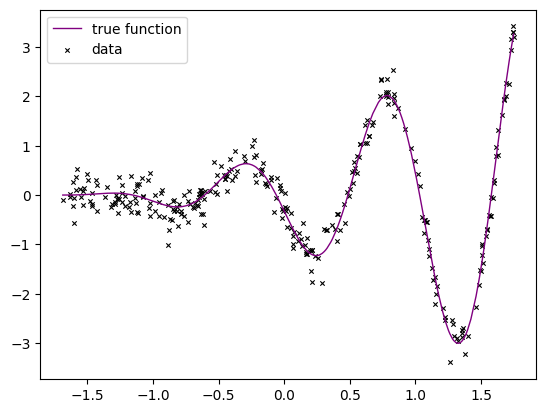

In [11]:

def some_function(x): 
    return jnp.sin(10*x)*x**2

N = 500
sigma = 0.25

rng_key, rng_subkey = random.split(rng_key)
x_true = random.uniform(rng_key, shape=(N,), minval=0, maxval=2)


rng_key, rng_subkey = random.split(rng_key)
noise =sigma*random.normal(rng_key, shape=x_true.shape)

y_true = some_function(x_true)
y_noise = some_function(x_true) + noise

x_test = jnp.linspace(start=0, stop=2, num=100)
y_test = some_function(x_test)
scaler = preprocessing.StandardScaler()
x_true = jnp.array(scaler.fit_transform(x_true[:, None]))
x_test = jnp.array(scaler.transform(x_test[:, None]))

idx = jnp.argsort(x_true.reshape(-1))
plt.plot(x_true[idx], y_true[idx], color = 'purple', linewidth = 1,   label = 'true function')
plt.scatter(x_true[:300], y_noise[:300], marker ='x', s=10,  linewidths = 0.8, color = 'black', label = 'data')
plt.legend()


### Run with mean-field VI

Choose activation, 'ReLU' or 'Sigmoid', number of hidden units in each layer (e.g. [200] encodes one layer choice with 200 hidden units) and parameters for training and predicting (learning rate, number of iterations and samples)

In [12]:
lrate = 5e-3
n_iters = 10000
hidd_layer = [200]
activation = 'ReLU'
n_samples = 1000

Train the network, obtain predictions and evaluate

In [ ]:

bnn = BNN(hidden_dims = hidd_layer, activation=activation)
bnn.prior_dist(x_true, n_samples)
bnn.doVI(x_true, y_noise, n_iters, lrate)
bnn.posterior_vi_dist(x_true, n_samples)
# uncomment if wish to obtain prior predictive
# prior = {'mu' : bnn.prior['mu'], 'sigma': bnn.prior['sigma'],  'obs': bnn.prior['obs']}
posterior = {'mu' : bnn.posterior_vi['mu'], 'sigma': bnn.posterior_vi['sigma']}
#  uncomment if wish to obtain elpd
# loglikelihood = log_lik(y_noise, posterior['mu'], posterior['sigma'])[None, ...]

# arvizvidata = az.from_dict(posterior={ k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior.items()},\
#                         prior={ k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in prior.items()},\
#                         log_likelihood={'obs': loglikelihood},\
#                         observed_data={'obs': y_noise},
# )

# az.loo(arvizvidata, pointwise=True)
# elpd, elpd_se, p_loo = az.loo(arvizvidata, pointwise=True).values[:3]
bnn.posterior_predictive_vi_dist(x_test, n_samples)
posterior_pred = {'mu' : bnn.posterior_predictive_vi['mu'], 'sigma': bnn.posterior_predictive_vi['sigma'],  'obs': bnn.posterior_predictive_vi['obs']}


cr_func = credintr(y_test, posterior_pred['mu'])
cr_total = credintr(y_test, posterior_pred['obs'])
y_mean = posterior_pred['mu'].mean(axis = 0).copy()
rm = rmse(y_test, y_mean)

print(' mfVI' + activation + str(hidd_layer[0]) + '\n RMSE is ' + str(round(rm.item(), 4))
      + '\n Training time is ' + str(round(bnn.train_time, 1)) + '\n empirical coverage for the function  is ' + str(cr_func) + '\n total empirical coverage is ' + str(cr_total))



100%|██████████| 10000/10000 [00:03<00:00, 2601.85it/s, init loss: 426511.1250, avg. loss [9501-10000]: 7967.4521]


training time (SVI) is  4.0705320835113525


Plot

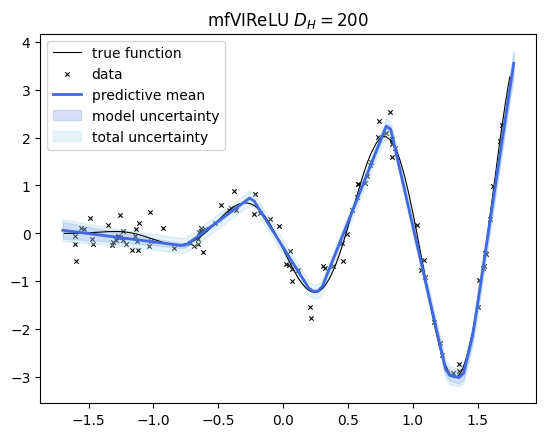

In [26]:


y_std = posterior_pred['mu'].std(axis = 0).copy()
y_std_total = posterior_pred['obs'].std(axis = 0).copy()

idx = np.argsort(x_true.squeeze())
plt.plot(x_true.squeeze()[idx], y_true[idx], color = 'black', linewidth = 0.8,   label = 'true function')    
plt.scatter(x_true.squeeze()[:100], y_noise[:100], marker ='x', s=10,  linewidths = 0.8, color = 'black', label = 'data')
plt.plot(x_test.squeeze(), y_mean, color = 'royalblue', linewidth = 2, label = 'predictive mean')
plt.fill_between(x_test.squeeze(), y_mean - 1.96*y_std, y_mean + 1.96*y_std, color = 'royalblue', alpha = 0.2, label = r"model uncertainty")
plt.fill_between(x_test.squeeze(), y_mean - 1.96*y_std_total, y_mean + 1.96*y_std_total, color = 'lightblue', alpha = 0.3, label = r"total uncertainty")

plt.legend()
plt.title('mfVI' + activation + r' $D_H =$' + str(bnn.hidden_dims[0]))
plt.show()







### Run with HMC

Choose activation, 'ReLU' or 'Sigmoid', number of hidden units in each layer (e.g. [200] encodes one layer choice with 200 hidden units) and parameters for training and predicting (number of chains and samples)

In [27]:
hidd_layer = [200]
n_warmup = 1000
n_samples = 1000
n_chains = 1
activations = 'ReLU'


Train the network, obtain predictions and evaluate

In [28]:

bnn = BNN(hidden_dims = hidd_layer, activation= activation)
# if want prior
# bnn.prior_dist(x_true, n_samples)
# prior = {'mu' : bnn.prior['mu'], 'sigma': bnn.prior['sigma'],  'obs': bnn.prior['obs']}
bnn.doMCMC(x_true, y_noise, n_warmup, n_samples, n_chains)

# uncomment if wish to obtain elpd
# posterior = {'mu' : bnn.posterior_mcmc['mu'], 'sigma': bnn.posterior_mcmc['sigma']}
# loglikelihood = log_lik(y_noise, posterior['mu'], posterior['sigma'])[None, ...]

# arvizmcmcdata = az.from_dict(posterior={ k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior.items()},\
#                         prior={ k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in prior.items()},\
#                         log_likelihood={'obs': loglikelihood},\
#                         observed_data={'obs': y_noise},
# )

# elpd, elpd_se, p_loo = az.loo(arvizmcmcdata, pointwise=True).values[:3]
# arvizmcmcdata.add_groups(posterior_predictive  ={ k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior_pred.items()} )

bnn.predict_mcmc(x_test)
posterior_pred = {'mu' : bnn.posterior_predictive_mcmc['mu'], 'sigma': bnn.posterior_predictive_mcmc['sigma'],  'obs': bnn.posterior_predictive_mcmc['obs']}

cr_func = credintr(y_test, posterior_pred['mu'])
cr_total = credintr(y_test, posterior_pred['obs'])

y_mean = posterior_pred['mu'].mean(axis = 0).copy()
rm = rmse(y_test, y_mean)

print(' HMC' + activation + str(hidd_layer[0]) + '\n RMSE is ' + str(round(rm.item(), 4))
      + '\n Training time is ' + str(round(bnn.train_time, 1)) + '\n empirical coverage for the function  is ' + str(cr_func) + '\n total empirical coverage is ' + str(cr_total))





sample: 100%|██████████| 2000/2000 [05:13<00:00,  6.38it/s, 1023 steps of size 5.34e-04. acc. prob=0.85]


training time (MCMC)  is  313.89818000793457
 HMCReLU200
 RMSE is 0.0558
 Training time is 313.9
 empirical coverage for the function  is 0.44
 total empirical coverage is 0.99


Plot

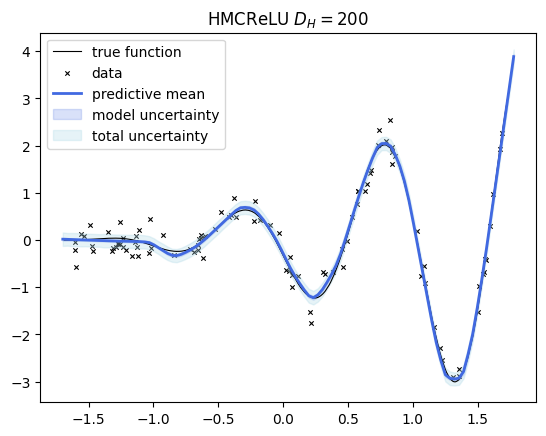

In [29]:

y_std = posterior_pred['mu'].std(axis = 0).copy()
y_std_total = posterior_pred['obs'].std(axis = 0).copy()

idx = np.argsort(x_true.squeeze())
plt.plot(x_true.squeeze()[idx], y_true[idx], color = 'black', linewidth = 0.8,   label = 'true function')    
plt.scatter(x_true.squeeze()[:100], y_noise[:100], marker ='x', s=10,  linewidths = 0.8, color = 'black', label = 'data')
plt.plot(x_test.squeeze(), y_mean, color = 'royalblue', linewidth = 2, label = 'predictive mean')
plt.fill_between(x_test.squeeze(), y_mean - 1.96*y_std, y_mean + 1.96*y_std, color = 'royalblue', alpha = 0.2, label = r"model uncertainty")
plt.fill_between(x_test.squeeze(), y_mean - 1.96*y_std_total, y_mean + 1.96*y_std_total, color = 'lightblue', alpha = 0.3, label = r"total uncertainty")

plt.legend()
plt.title('HMC' + activation + r' $D_H =$' + str(bnn.hidden_dims[0]))
plt.show()